### ModelCheckpoint, Confusion Matrix, ROC curve

In [14]:
%autosave 0
import os
import time

import numpy as np
import seaborn as sb

import tensorflow
import tensorflow as tf

# tensorflow 2.0
from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용 함수
from tensorflow.keras.layers import Dense       # 전결합층
from tensorflow.keras.callbacks import EarlyStopping # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 모델 저장
from tensorflow.keras.optimizers import Adam    # 가중치, bias 최적화
from tensorflow.keras.utils import plot_model   # 네트워크 입출력 시각화

from sklearn.model_selection import train_test_split # 훈련/검증 데이터 분할
from sklearn.metrics import confusion_matrix  # 혼돈행렬, 이항분류 시각화
from sklearn.metrics import roc_curve         # 분류 품질 시각화 

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
rc('font', family='Malgun Gothic')


Autosave disabled


In [15]:
data = np.loadtxt('./wine.csv', delimiter=",", dtype=np.float64)
print(type(data))
print(data.shape)  # 6497행 13열

<class 'numpy.ndarray'>
(6497, 13)


In [16]:
X = data[:, 0:12]  # 0 ~ 11, 12개의 데이터 변수 추출
print(X.shape)     # 2차원 배열
Y = data[:, 12]    # 13번째 변수, class, 정답
print(Y.shape)     # 1차원 배열

(6497, 12)
(6497,)


In [17]:
# train_test_split 분할을 통한 훈련, 검증, 테스트 데이터의 분리
# 데이터를 3그룹으로 분할: test 5% -> 95%(train 80%, validation 20%)
seed = 0
# stratify=Y: 0과 1의 분류 비율을 동일하게 데이터를 분할해줌.
# 95%: 분할대기(x_train_all), 5%: 테스트(x_test)
# x_train_all: 훈련 데이터 95% 분할 대기
# x_test: 테스트 데이터 5% 분할
# y_train_all: 훈련 target(class) 95% 분할 대기
# y_test: 테스트 target(class) 5% 분할
x_train_all, x_test, y_train_all, y_test = train_test_split(X, Y,
                                                  stratify=Y,
                                                  test_size=0.05,
                                                  random_state=seed)
# 나머지 데이터 95%를 분할, 80%: 훈련(x_train), 20%: 검증(x_val)
# x_train: 훈련 데이터 80% 분할
# x_val: 검증 데이터 20% 분할
# y_train: 훈련 target(class) 80% 분할
# y_val: 검증 target(class) 20% 분할
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all,
                                                  test_size=0.2,
                                                  random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(y_train[0:100]) # 검증 Target 100건만 출력


(4937, 12)
(4937,)
[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0.]


In [18]:
tf.random.set_seed(0)
model = Sequential()
model.add(Dense(10, input_dim=12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# patience=5: 학습 결과가 개선되지 않아도 학습을 진행할 횟수
# restore_best_weights=True: 학습 종료시 가장 우수한 가중치, 편향으로 저장
es = EarlyStopping(monitor='loss',patience=5, restore_best_weights=True)

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR): # 폴더가 존재하지 않으면 생성
    os.mkdir(MODEL_DIR) # 폴더 생성

# 03d: 좌측 0 padding 정수 3자리, .4f: 실수 소수점 4자리 
modelpath='./model/{epoch:03d}-{val_accuracy:.4f}.h5'  
# epoch:03d: 부족한 자리를 0으로 채우는 정수 형식
# val_accuracy:.4f: 소수이하 4째자리까지 표현 형식

# 검증 정확도가 개선되었을 때만 학습 모델 파일로 저장
# filepath=modelpath: 파일이 저장되는 경로와 파일명
# monitor='val_accuracy': 검증 정확도 기준으로 판단
# verbose=1: 기록되는 파일 정보 출력
# save_best_only=True: 검증 정확도가 개선되면 파일로 저장
mcp= ModelCheckpoint(filepath=modelpath,
                    monitor='val_accuracy',
                    verbose=1, save_best_only=True)

start = time.time()
hist = model.fit(x_train, y_train, validation_split=0.2, shuffle=True,epochs=1000, batch_size=1 ,callbacks=[es])

end = time.time()
print('Runtime: {0:.0f}초'.format(end-start))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                130       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
3949/3949 [==============================] - 3s 777us/step - loss: 0.6955 - accuracy: 0.8939 - val_loss: 0.1459 - val_accuracy: 0.9433
Epoch 2/1000
3949/3949 [==============================] - 3s 733us/step - loss: 0.2121 - accuracy: 0.9241 - val_loss: 0.1490 - val_accuracy: 0.9464
Epoch 3/1000
3949/3949 [==============================] - 3s 737us/step - loss: 0.1621 - accuracy: 0.9442 - val_loss: 0.0874 - val_accuracy: 0.9686
Epoch 4/1000
3949/3949 [==============================] - 3s 722us/step - 

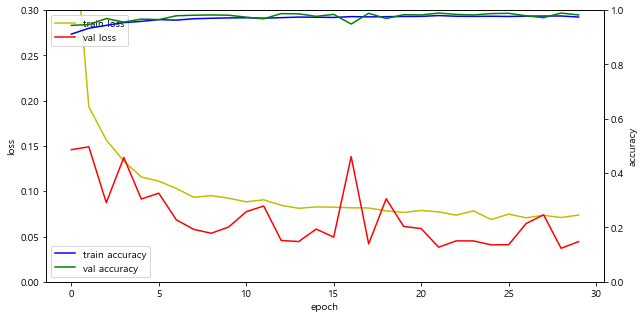

In [19]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()   # 오른쪽 y 축 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 0.3]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1]) # 0.0, 1: 0 ~ 100 %, 정확도임으로 변경하지 않음

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

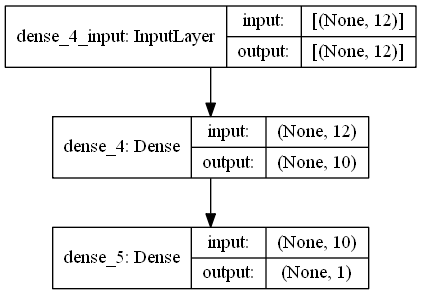

In [20]:
plot_model(model, to_file='./Wine2.png', show_shapes=True, show_layer_names=True)

In [21]:
# verbose=0: 처리과정의 메시지 생략
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.05792376771569252 /정확도: 99.07692074775696 %


In [22]:
#model.save('./Wine2.h5')

In [31]:
model = load_model('./Wine2.h5')
#model = load_model('./model/020-0.9822.h5') # ModelCheckPoint에서 저장됨

In [25]:
p = model.predict(x_test[0:100])
print(p.shape)

(100, 1)


In [26]:
for i in range(len(x_test[0:100])):
    fmt = '실제값: {0}, 예측값: {1}'
    print(fmt.format(y_test[i], p[i]), end='')
    
    # 임계값의 지정, 정확도를 참고하여 판단, 60%이상 합격: 0.6
    if (p[i] >= 0.5): 
        print('--> Red 와인')   # 1
    else:
        print('--> White 와인') # 0

실제값: 0.0, 예측값: [3.314938e-07]--> White 와인
실제값: 0.0, 예측값: [1.6643385e-08]--> White 와인
실제값: 1.0, 예측값: [0.99228907]--> Red 와인
실제값: 0.0, 예측값: [0.00023958]--> White 와인
실제값: 1.0, 예측값: [0.9990704]--> Red 와인
실제값: 1.0, 예측값: [0.9960212]--> Red 와인
실제값: 0.0, 예측값: [0.00036326]--> White 와인
실제값: 0.0, 예측값: [0.0002152]--> White 와인
실제값: 0.0, 예측값: [0.4330002]--> White 와인
실제값: 0.0, 예측값: [0.00212356]--> White 와인
실제값: 1.0, 예측값: [0.99366033]--> Red 와인
실제값: 0.0, 예측값: [0.00180998]--> White 와인
실제값: 0.0, 예측값: [5.3129756e-05]--> White 와인
실제값: 1.0, 예측값: [0.99882686]--> Red 와인
실제값: 0.0, 예측값: [1.8416744e-05]--> White 와인
실제값: 0.0, 예측값: [0.00179428]--> White 와인
실제값: 0.0, 예측값: [0.00023812]--> White 와인
실제값: 1.0, 예측값: [0.967186]--> Red 와인
실제값: 0.0, 예측값: [5.8528516e-05]--> White 와인
실제값: 1.0, 예측값: [0.9995866]--> Red 와인
실제값: 0.0, 예측값: [2.2233104e-05]--> White 와인
실제값: 0.0, 예측값: [4.4155717e-05]--> White 와인
실제값: 0.0, 예측값: [3.8553026e-05]--> White 와인
실제값: 0.0, 예측값: [0.00021058]--> White 와인
실제값: 1.0, 예측값: [0.9963776]--> Red 와인
실

In [27]:
red = 0
white = 0
for i in range(len(y_test)):
    if y_test[i] == 1:  # red wine 인지 검사
        red = red + 1
    else:
        white = white + 1

print('Red wine:', red)
print('White wine:', white)

Red wine: 80
White wine: 245


In [28]:
# 결과 - 혼돈 행렬, # class 0우선으로 즉 오름차순으로 표가 생성
print(x_test.shape)
y_test_pred = model.predict_classes(x_test)  # 모델 테스트
c_matrix = confusion_matrix(y_test, y_test_pred) # 실제값, 예측값
print(type(c_matrix))
print(c_matrix)
# [[white wine 맞춘 갯수   white wine 틀린 갯수]
#  [red wine 틀린 갯수     red wine 맞춘 갯수]]

(325, 12)
<class 'numpy.ndarray'>
[[245   0]
 [  3  77]]


C:\ProgramData\Anaconda3\envs\ai\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


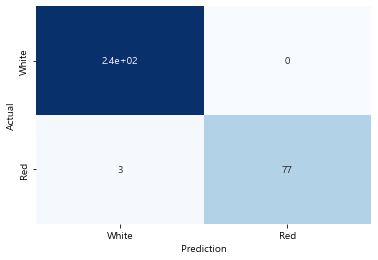

<Figure size 432x288 with 0 Axes>

In [29]:
ax = sb.heatmap(c_matrix, annot=True, 
                 xticklabels=['White', 'Red'], 
                 yticklabels=['White', 'Red'], cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
plt.show()
plt.clf()
# [[white wine 맞춘 갯수   white wine 틀린 갯수]
#  [red wine 틀린 갯수     red wine 맞춘 갯수]]

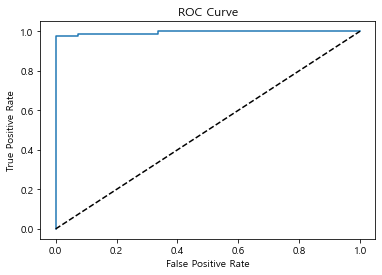

<Figure size 432x288 with 0 Axes>

In [30]:
# 결과 - ROC 곡선
y_test_pred_probs = model.predict(x_test)
# print(y_test_pred_probs)
FPR, TPR, _ = roc_curve(y_test, y_test_pred_probs)
plt.plot(FPR, TPR)
plt.plot([0,1],[0,1],'--', color='black') #diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
plt.clf()